In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import find_peaks
import os


file_path = "scope_60.csv"  


Estimated sampling frequency: 400.00 Hz
Estimated heart rate: 87.5 BPM


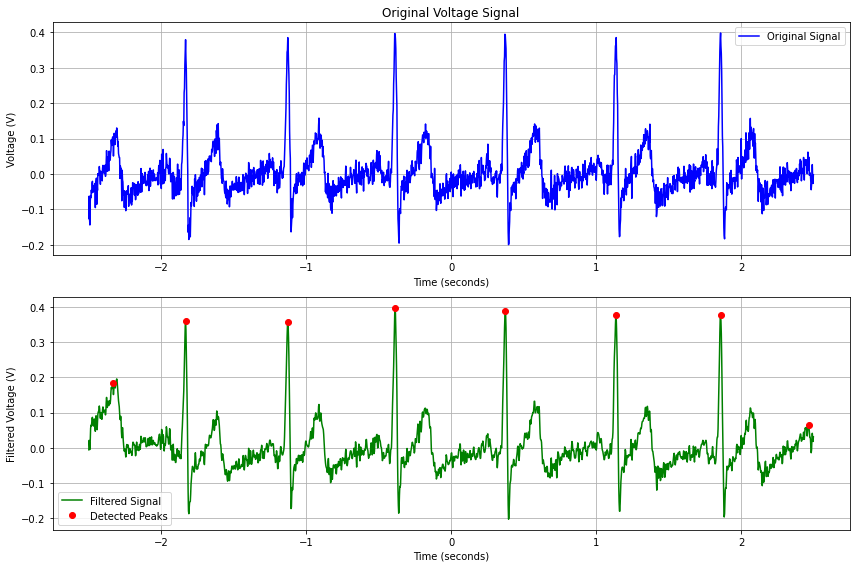

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import find_peaks
import os


file_path = "scope_60.csv"

try:
    
    with open(file_path, "r") as file:
        lines = file.readlines()

    
    data_lines = lines[2:]  

    
    time_values = []
    voltage_values = []

    for line in data_lines:
        line = line.strip()
        if line:  
            time_str, voltage_str = line.split(",")
            time_values.append(float(time_str))
            voltage_values.append(float(voltage_str))

    
    time = np.array(time_values)
    voltage = np.array(voltage_values)

    
    if len(time) > 1:
        
        dt = np.mean(np.diff(time))
        fs = 1 / abs(dt)  
    else:
        fs = 1  

    print(f"Estimated sampling frequency: {fs:.2f} Hz")

    
    
    order = 3  
    lowcut = 0.5  # Hz
    highcut = 100  # Hz

    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = signal.butter(order, [low, high], btype="band")
        return b, a

    def butter_bandstop(lowcut, highcut, fs, order=10):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = signal.butter(order, [low, high], btype="bandstop")
        return b, a

    def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = signal.filtfilt(b, a, data)
        return y

    def butter_bandstop_filter(data, lowcut, highcut, fs, order=10):
        b, a = butter_bandstop(lowcut, highcut, fs, order=order)
        y = signal.filtfilt(b, a, data)
        return y

    def combined_filter(data, bp_lowcut, bp_highcut, bs_lowcut, bs_highcut, fs, bp_order=5, bs_order=5):
        bandpassed = butter_bandpass_filter(data, bp_lowcut, bp_highcut, fs, bp_order)
        filtered = butter_bandstop_filter(bandpassed, bs_lowcut, bs_highcut, fs, bs_order)
        
        return filtered

    
    filtered_voltage = combined_filter(voltage, lowcut, highcut , 49 , 51 , fs, order , 5 )

    
    
    distance = int(fs * 0.5)  
    peaks, _ = find_peaks(filtered_voltage, distance=distance)

    
    if len(peaks) > 1:
        
        peak_times = time[peaks]
        intervals = np.diff(peak_times)
        mean_interval = np.mean(intervals)

        
        heart_rate = 60 / mean_interval
        print(f"Estimated heart rate: {heart_rate:.1f} BPM")

    
    plt.figure(figsize=(12, 8))

    
    plt.subplot(2, 1, 1)
    plt.plot(time, voltage, "b-", label="Original Signal")
    plt.grid(True)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Voltage (V)")
    plt.title("Original Voltage Signal")
    plt.legend()

    
    plt.subplot(2, 1, 2)
    plt.plot(time, filtered_voltage, "g-", label="Filtered Signal")
    plt.plot(time[peaks], filtered_voltage[peaks], "ro", label="Detected Peaks")


    plt.grid(True)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Filtered Voltage (V)")
    plt.legend()

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"err {e}")
    import traceback
    traceback.print_exc()